### PupilAnalysis_Pain - Data Processing
- Perform signal processing and preprocessing
    - Remove empty cells (outliers)
    - Calculate signal loss
    - Rebuild signal loss intervals (data missing)
    - Smooth the signal

### Step 0: Load Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from tqdm import tqdm
import time
from skimage import io
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Step 1: Load the dataset

In [2]:
# Enter the path where the exported database was stored
# Put the letter r before the path to avoid misinterpretation of the backslash
df = pd.read_csv(r"C:\Users\Rafae\Desktop\Emotion_Effect\Wilson\database.tsv", sep="\t") #Read file

### Step 2: View loaded data properties

In [3]:
# Check in which pupil there was the greatest signal loss
# Print number of valid Samples (without NaN) from the Left Pupil
print("Left pupil samples:",df.PupilLeft.count())
# Print number of valid Samples (without NaN) from the Right Pupil
print("Right pupil samples:",df.PupilRight.count()) 

Left pupil samples: 1976029
Right pupil samples: 1968806


In [4]:
# Filter NaN and print name of all stimuli
print("Stimuli:",np.unique(df[df["MediaName"].notna()].MediaName)) 

Stimuli: ['1710.jpg' '2040.jpg' '2045.jpg' '2050.jpg' '2058.jpg' '2080.jpg'
 '2205.jpg' '2722.jpg' '3220.jpg' '6010.jpg' '7520.jpg' '7521.jpg'
 '8501.jpg' '8502.jpg' '8503.jpg' '9000.jpg' '9001.jpg' '9220.jpg']


In [5]:
# Prints the identification of all subjects
print("RecordingName:",np.unique(df.RecordingName)) 

RecordingName: ['Rec 01' 'Rec 02' 'Rec 03' 'Rec 04' 'Rec 05' 'Rec 06' 'Rec 07' 'Rec 08'
 'Rec 09' 'Rec 10' 'Rec 11' 'Rec 12' 'Rec 13' 'Rec 14' 'Rec 15' 'Rec 16'
 'Rec 17' 'Rec 18' 'Rec 19' 'Rec 20' 'Rec 21' 'Rec 22' 'Rec 23' 'Rec 24'
 'Rec 25' 'Rec 26' 'Rec 27' 'Rec 28' 'Rec 29' 'Rec 30' 'Rec 31' 'Rec 32'
 'Rec 33' 'Rec 34' 'Rec 35' 'Rec 36']


In [6]:
# Check if it is necessary to exclude or convert the type of some variable
print(df.info()) # Print summary of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562185 entries, 0 to 2562184
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   RecordingName  object 
 1   MediaName      object 
 2   PupilLeft      float64
 3   PupilRight     float64
 4   Unnamed: 4     float64
dtypes: float64(3), object(2)
memory usage: 97.7+ MB
None


### Step 3: Organize and clean the dataset
- In this step, instead of excluding the data that you are not going to use, select only the data that you are going to use and overwrite the database

In [7]:
# Select only the columns you are going to user
df = df[['RecordingName','MediaName','PupilLeft']]
# Rename the Pupil with the most recorded samples to "Pupil"
df.rename(columns = {'RecordingName':'ParticipantName','PupilLeft':'Pupil'}, inplace = True)
display(df)

ParticipantName MediaName  Pupil
0                Rec 01       NaN   4.10
1                Rec 01       NaN   4.10
2                Rec 01       NaN   4.10
3                Rec 01       NaN   4.10
4                Rec 01       NaN   4.08
...                 ...       ...    ...
2562180          Rec 36       NaN    NaN
2562181          Rec 36       NaN    NaN
2562182          Rec 36       NaN    NaN
2562183          Rec 36       NaN    NaN
2562184          Rec 36       NaN    NaN

[2562185 rows x 3 columns]

In [8]:
# Removed: 20, 22, 24, 26, 31
p = ['Rec 01', 'Rec 02', 'Rec 03', 'Rec 04', 'Rec 05', 'Rec 06', 'Rec 07', 'Rec 08', 'Rec 09', 'Rec 10',
     'Rec 11', 'Rec 12', 'Rec 13', 'Rec 14', 'Rec 15', 'Rec 16', 'Rec 17', 'Rec 18', 'Rec 19', 'Rec 21',
     'Rec 23', 'Rec 25', 'Rec 27', 'Rec 28', 'Rec 29', 'Rec 30', 'Rec 32', 'Rec 33', 'Rec 34', 'Rec 35',
     'Rec 36']

# Select only participants from the list and overwrite the dataset
df = df[df.ParticipantName.isin(p)] 
display(df)

ParticipantName MediaName  Pupil
0                Rec 01       NaN   4.10
1                Rec 01       NaN   4.10
2                Rec 01       NaN   4.10
3                Rec 01       NaN   4.10
4                Rec 01       NaN   4.08
...                 ...       ...    ...
2562180          Rec 36       NaN    NaN
2562181          Rec 36       NaN    NaN
2562182          Rec 36       NaN    NaN
2562183          Rec 36       NaN    NaN
2562184          Rec 36       NaN    NaN

[2211023 rows x 3 columns]

In [11]:
positive = ['8501.jpg', '2080.jpg', '2050.jpg', '2040.jpg', '8502.jpg', '2058.jpg', '1710.jpg', '8503.jpg', '2045.jpg']
negative = ['2722.jpg', '9220.jpg', '7521.jpg', '9001.jpg', '9000.jpg', '2205.jpg', '6010.jpg', '3220.jpg', '7520.jpg']

stimuli = positive+negative

df = df[df.MediaName.isin(stimuli)] 
display(df)

ParticipantName MediaName  Pupil
5139             Rec 01  8501.jpg   4.95
5140             Rec 01  8501.jpg    NaN
5141             Rec 01  8501.jpg    NaN
5142             Rec 01  8501.jpg    NaN
5143             Rec 01  8501.jpg    NaN
...                 ...       ...    ...
2560536          Rec 36  2045.jpg   4.50
2560537          Rec 36  2045.jpg   4.49
2560538          Rec 36  2045.jpg   4.50
2560539          Rec 36  2045.jpg   4.47
2560540          Rec 36  2045.jpg   4.49

[1006366 rows x 3 columns]

### Step 4: Fix data type and format

In [12]:
# Replace comma with dot, use regex parameter to apply to df
df["Pupil"] = df["Pupil"].replace(",",".", regex=True)
# Convert data type to numeric (Float)
df["Pupil"] = pd.to_numeric(df["Pupil"]) 
display(df)

ParticipantName MediaName  Pupil
5139             Rec 01  8501.jpg   4.95
5140             Rec 01  8501.jpg    NaN
5141             Rec 01  8501.jpg    NaN
5142             Rec 01  8501.jpg    NaN
5143             Rec 01  8501.jpg    NaN
...                 ...       ...    ...
2560536          Rec 36  2045.jpg   4.50
2560537          Rec 36  2045.jpg   4.49
2560538          Rec 36  2045.jpg   4.50
2560539          Rec 36  2045.jpg   4.47
2560540          Rec 36  2045.jpg   4.49

[1006366 rows x 3 columns]

### Step 5: Analyze signal loss by participant
- Commonly, the criterion of 70% of valid samples is used
    - Check if the signal acquisition rate is equal to or higher than the stipulated criterion
    - Remove participants with acquisition rate below the criteria

In [13]:
# Declare lists to store the amount of samples
lista1 = []; lista2 = []; lista3 = []  
# Loop repeat to list all participants
for i in p:
    # Filter the participant
    dfi = df["ParticipantName"]==i
    # Filter all samples of the participant
    lista1.append(len(df[dfi]))
    # Filter only samples recorded, without NaN
    lista2.append(len(df[dfi][df[dfi]["Pupil"].notna()]))
    # Calculate rec rate
    lista3.append(len(df[dfi][df[dfi]["Pupil"].notna()])/len(df[dfi]))
# Create Report    
report = pd.DataFrame(data={'AllSamples':lista1,
                            'ValidSamples':lista2,
                            'RecRate':lista3}, index=[p]) 
display(report) 

AllSamples  ValidSamples   RecRate
Rec 01       32467         28034  0.863461
Rec 02       32464         29687  0.914459
Rec 03       32458         23750  0.731715
Rec 04       32464         30334  0.934389
Rec 05       32457         31301  0.964384
Rec 06       32462         28399  0.874838
Rec 07       32464         26556  0.818014
Rec 08       32464         31889  0.982288
Rec 09       32460         30803  0.948953
Rec 10       32463         31777  0.978868
Rec 11       32459         31735  0.977695
Rec 12       32462         30887  0.951482
Rec 13       32469         32264  0.993686
Rec 14       32458         31435  0.968482
Rec 15       32463         32307  0.995195
Rec 16       32462         30793  0.948586
Rec 17       32467         31979  0.984969
Rec 18       32457         26899  0.828758
Rec 19       32466         30738  0.946775
Rec 21       32462         31834  0.980654
Rec 23       32459         30835  0.949968
Rec 25       32465         31658  0.975142
Rec 27       32451         29266  0.901852
Rec 28       32466         25818  0.795232
Rec 29       32458         30343  0.934839
Rec 30       32462         31082  0.957489
Rec 32       32469         29410  0.905787
Rec 33       32466         29648  0.913202
Rec 34       32472         30346  0.934528
Rec 35       32476         30003  0.923851
Rec 36       32474         28498  0.877564

In [14]:
# Check if there is any participant with acquisition rate below the criteria
criterio = 0.7 # Define criteria (normally 70% is used)
dfc = report['RecRate'] < criterio 
display(report[dfc])
# If you need to remove a participant, edit the 2nd part of step 3

Empty DataFrame
Columns: [AllSamples, ValidSamples, RecRate]
Index: []

### Step 6 - Data processing
- Outlier removal
- Reconstruction of signal loss intervals (missing data)
- Signal smoothing to remove noise
- Data normalization (change)

In [89]:
# Replace outliers to NaN
# Define a filter factor for outliers
factor = 0.04 
# Declare an auxiliary DataFrame
df2 = pd.DataFrame(columns=['ParticipantName','MediaName','Pupil']) 

for k in tqdm(range(0,len(p))):
    for j in range(0,len(stimuli)):
        # Filter participant and stimuli
        dftemp = df.loc[(df["ParticipantName"]==p[k])&(df["MediaName"]==stimuli[j])] 
        # Check if there is a difference between samples larger than the factor
        # or if the sample is NaN (in ascending order)
        for i in range(0,len(dftemp)-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan
        # Check if there is a difference between samples larger than the factor
        # or if the sample is NaN (in descending order)  
        for i in range(len(dftemp)-1,0,-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan       
        # Perform signal reconstruction by linear interpolation
        interpolated = dftemp.loc[:,'Pupil'].interpolate(method='linear',
                                                         limit_direction='both') 
        # Smooth the signal to remove noise
        smoothed = savgol_filter(interpolated, 15, 3) 
        # Normalize data variation (change)
        change = smoothed-smoothed[0] 
        for i in range(0,len(dftemp)-1):
            dftemp.iat[i,2] = change[i]
        # Add base signal treated in auxiliary DataFrame    
        df2 = pd.concat([df2,dftemp.iloc[0:1800,0:3]])

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [11:55<00:00, 23.09s/it]


### Step 7 - Visual analysis of the result

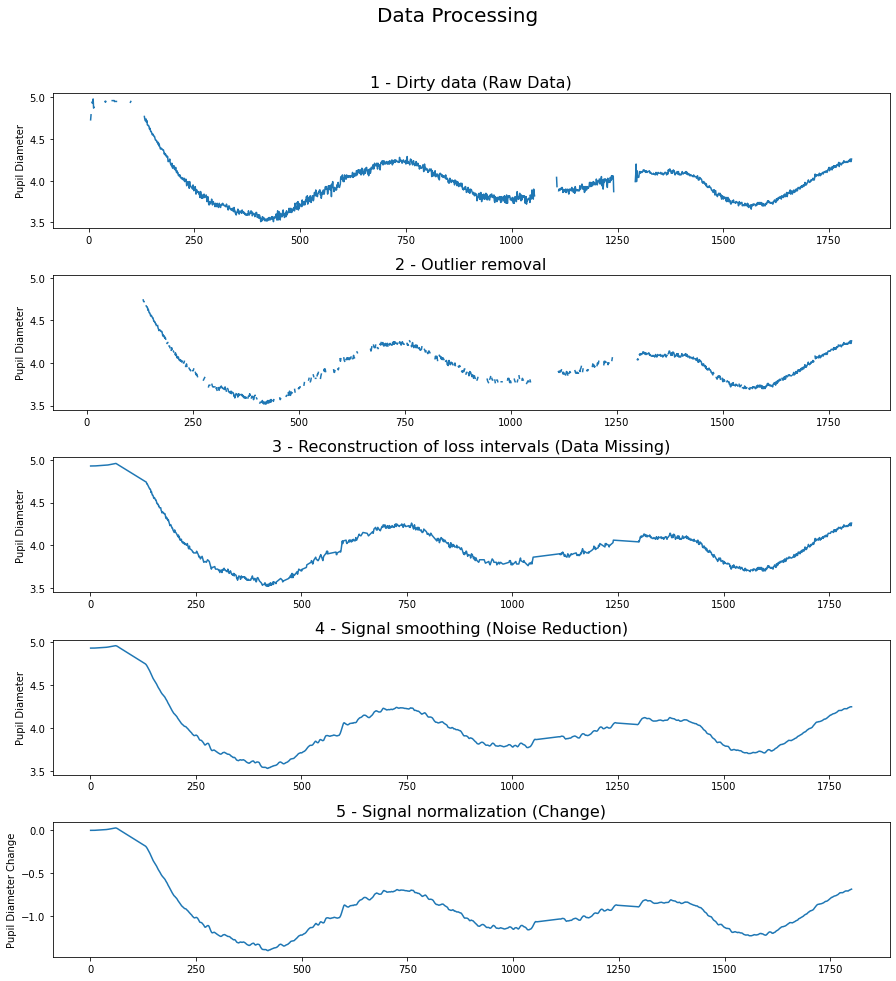

<Figure size 432x288 with 0 Axes>

In [90]:
plt.figure(figsize = (15, 15)) # Set plot area

# Dirty Data
# Filter participant and stimulus
dftemp = df.loc[(df["ParticipantName"]==p[0])&(df["MediaName"]==stimuli[1])] 
x = list(range(1,len(dftemp['Pupil'])+1)) # Set the abscissa axis
y = dftemp["Pupil"] # Print untreated data
plt.subplot(5, 1, 1)
plt.plot(x,y)
plt.title("1 - Dirty data (Raw Data)", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Removal of Outliers
factor = 0.04 # Define a filter factor for outliers
for i in range(0,len(dftemp)-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
# Check if there is a difference between samples larger than the factor
# or if the sample is NaN (in descending order) 
for i in range(len(dftemp)-1,0,-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
                
y = dftemp["Pupil"] # Print data without Outliers
plt.subplot(5, 1, 2)
plt.plot(x,y)
plt.title("2 - Outlier removal", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Perform signal reconstruction by linear interpolation
y = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
plt.subplot(5, 1, 3)
plt.plot(x,y)
plt.title("3 - Reconstruction of loss intervals (Data Missing)", fontsize = 16)
plt.ylabel('Pupil Diameter')

y = savgol_filter(y, 15, 3) # Smooth the signal to remove noise
x = list(range(1,len(y)+1))
plt.subplot(5, 1, 4)
plt.plot(x,y)
plt.title("4 - Signal smoothing (Noise Reduction)", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Data after all treatment steps
# Filter participant and stimulus
y = df2.loc[(df["ParticipantName"]==p[0])&(df2["MediaName"]==stimuli[1])] 
x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
plt.subplot(5, 1, 5)
plt.plot(x,y['Pupil'])
plt.title("5 - Signal normalization (Change)", fontsize = 16)
plt.ylabel('Pupil Diameter Change')

plt.suptitle("Data Processing", fontsize = 20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.5, hspace=0.35)
plt.show()
plt.savefig('DataProcessing.pdf')

## PupilAnalysis_Pain - Data visualization
- Organize variables of the pupil sign
- Visualize each subject's pupil sign
- Calculate average signal by class
- View average signal by class
- View pupil sign by stimulus
- Analyze the particularities of the pupil sign

### Step 8: Configure functions to generate results

In [91]:
# Function to calculate mean sign by class
def sign_class(classe,id):
    # preallocates space to store pupil sign 
    z = np.zeros(shape=(len(classe), 1800)) 
    k = 0 # Start counter
    for i in classe:
        # Filter subject and stimulus
        w = df2.loc[(df2["ParticipantName"]==i)&(df2["MediaName"]==id)] 
        z[k,:]=w['Pupil'] # Store subject's sign 
        k = k+1 # Increment counter
    y = np.mean(z, axis=0) # Calculate the class mean
    x = list(range(1,len(y)+1)) # Set the abscissa axis
    g = plt.plot(x,y) # Print mean sign
    return g

In [92]:
# Function to print original image (stimuli),
# sign of each subject and mean sign by class
def result_id(id1,id2):
    plt.figure(figsize=(15,5)) # Set plot area
    
    plt.subplot(1,2,1) # Set position of subplot
    plt.imshow(io.imread(id2)) # Print orriginal imagem
    plt.title('id: ' + id1, fontsize=13, loc='left') # Set title
    plt.axis('off') # Remove axis
    
    plt.subplot(1,2,2) # Set position of subplot
    for i in p:
        # Filter the subjects and stimuli
        y = df2.loc[(df2["ParticipantName"]==i)&(df2["MediaName"]==id1)] 
        x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
        plt.plot(x,y['Pupil']) # Set subject's pupil sign
    plt.title("Pupil sign of all subjects", fontsize = 15) # Insert title
    plt.ylabel('Pupil Diameter Change (mm)') # Insert label of the ordinate axis   
    
    #plt.subplot(2,2,4) # Set position of subplot
    #sign_class(p,id) # Print mean sign
    #plt.legend(['Mean']) # Insert legend
    #plt.title("Mean of pupil sign", fontsize = 15) # Insert title
    #plt.ylabel('Pupil Diameter Change (mm)') # Insert label of the ordinate axis
    return

### Step 9: View characteristics of the pupil sign

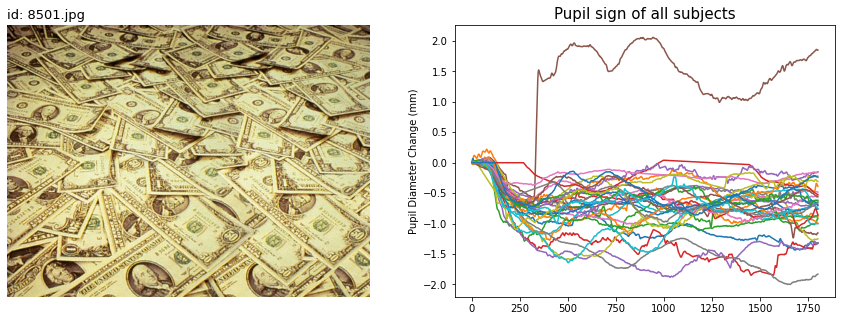

In [93]:
result_id(stimuli[0],stimuli[0]) 

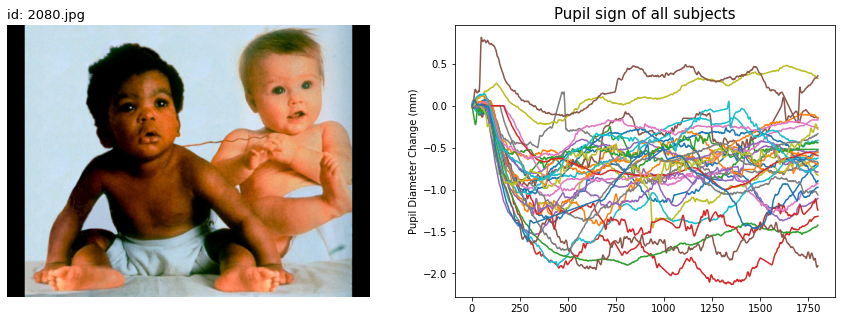

In [94]:
result_id(stimuli[1],stimuli[1]) 

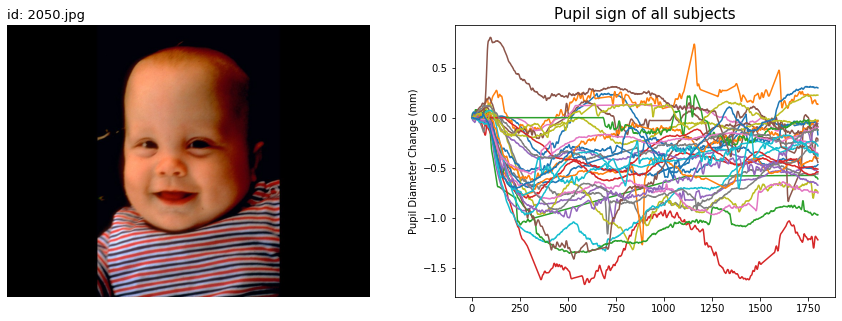

In [95]:
result_id(stimuli[2],stimuli[2]) 

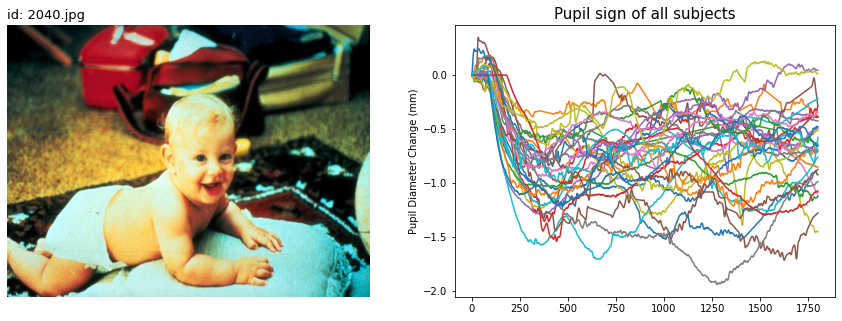

In [96]:
result_id(stimuli[3],stimuli[3]) 

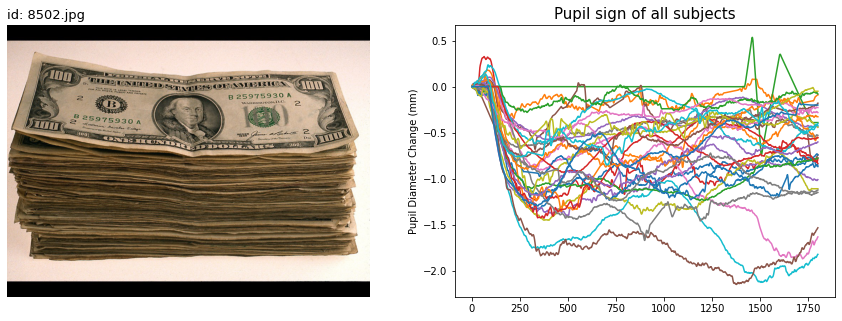

In [97]:
result_id(stimuli[4],stimuli[4]) 

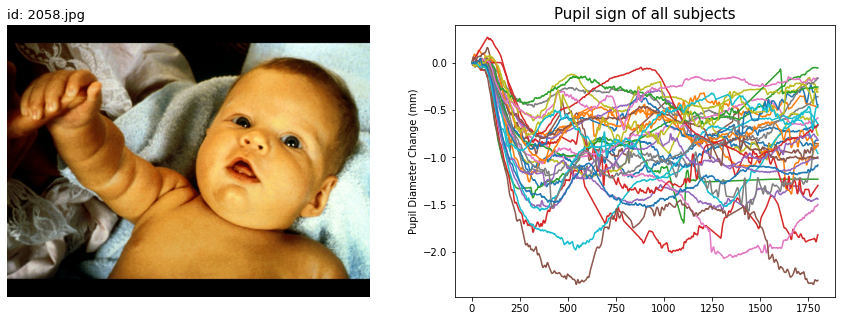

In [98]:
result_id(stimuli[5],stimuli[5]) 

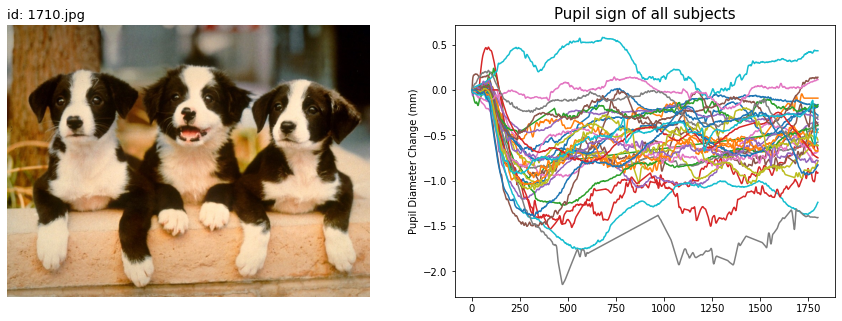

In [99]:
result_id(stimuli[6],stimuli[6]) 

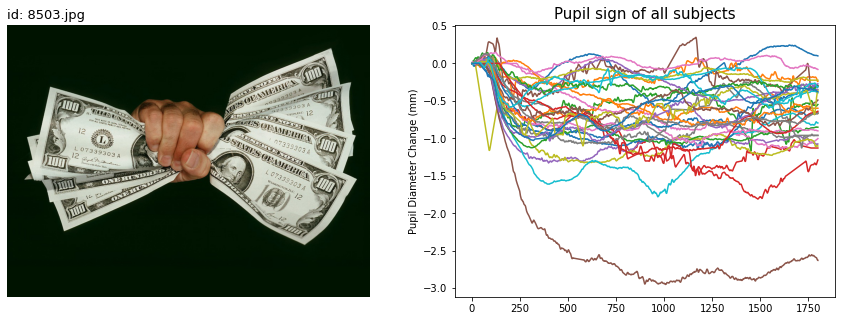

In [100]:
result_id(stimuli[7],stimuli[7]) 

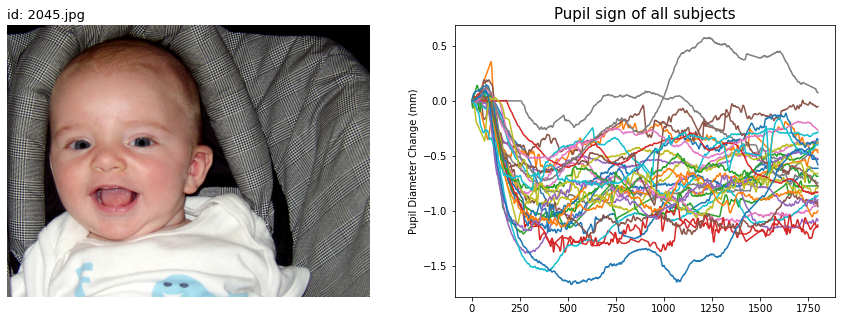

In [101]:
result_id(stimuli[8],stimuli[8]) 

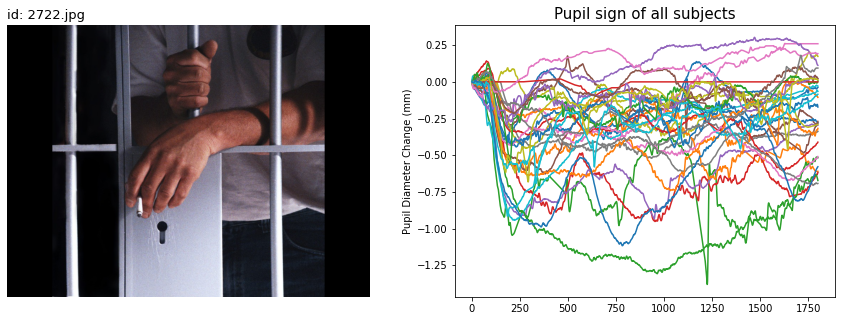

In [102]:
result_id(stimuli[9],stimuli[9]) 

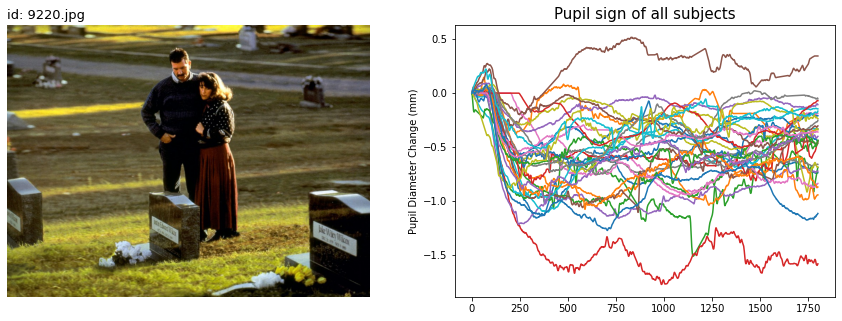

In [103]:
result_id(stimuli[10],stimuli[10]) 

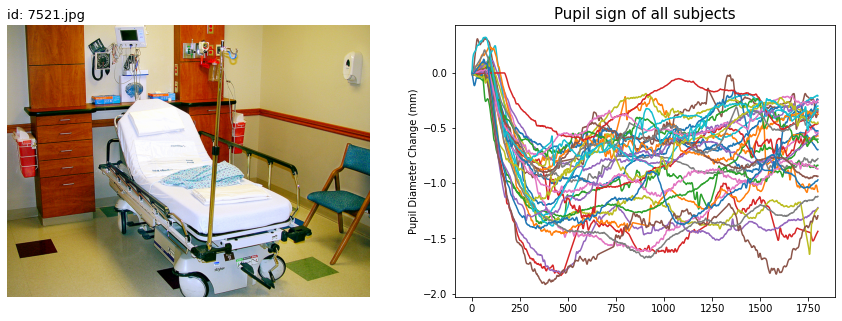

In [104]:
result_id(stimuli[11],stimuli[11])

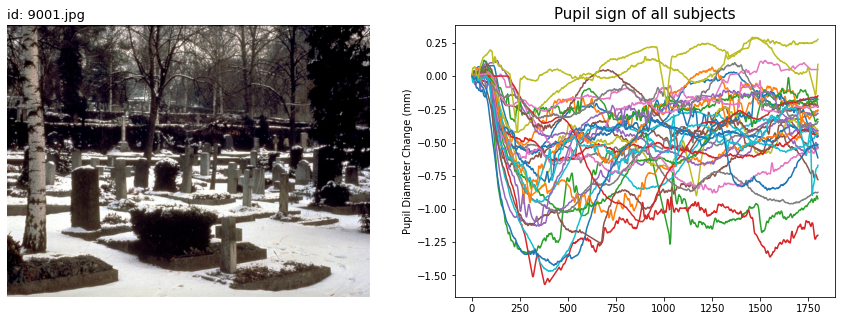

In [105]:
result_id(stimuli[12],stimuli[12])

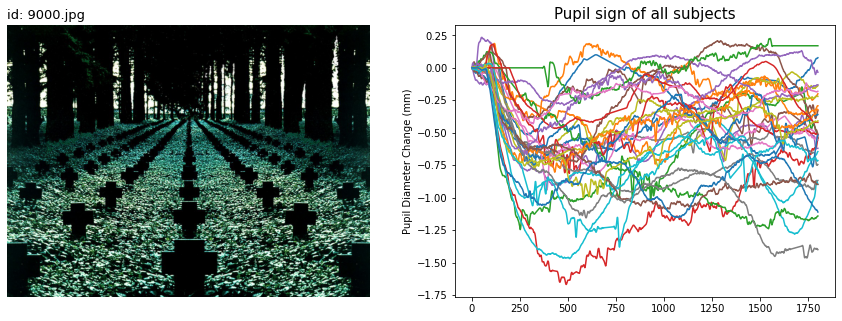

In [106]:
result_id(stimuli[13],stimuli[13])

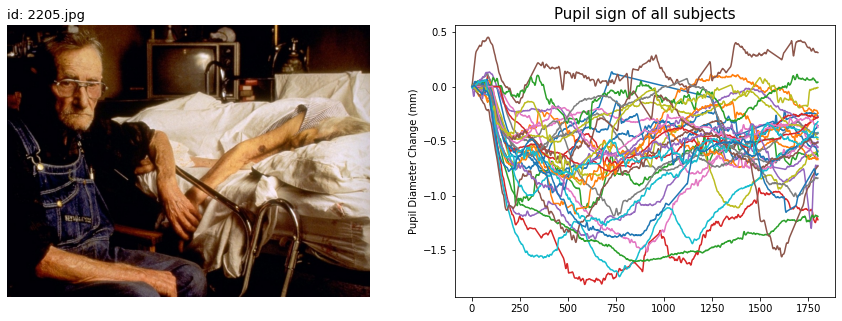

In [107]:
result_id(stimuli[14],stimuli[14])

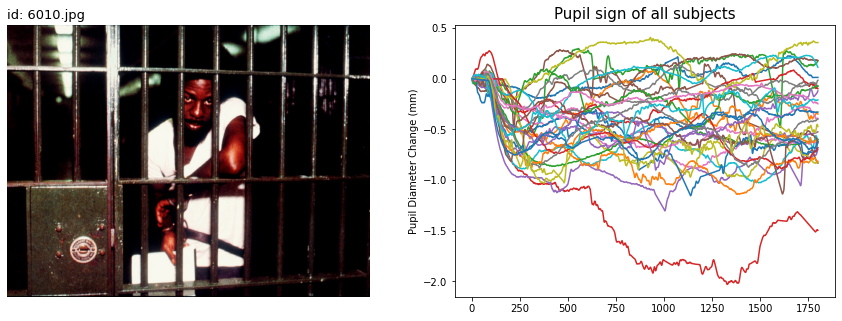

In [108]:
result_id(stimuli[15],stimuli[15])

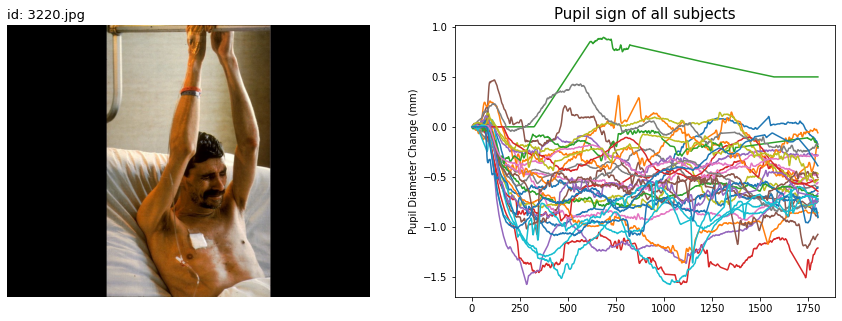

In [109]:
result_id(stimuli[16],stimuli[16])

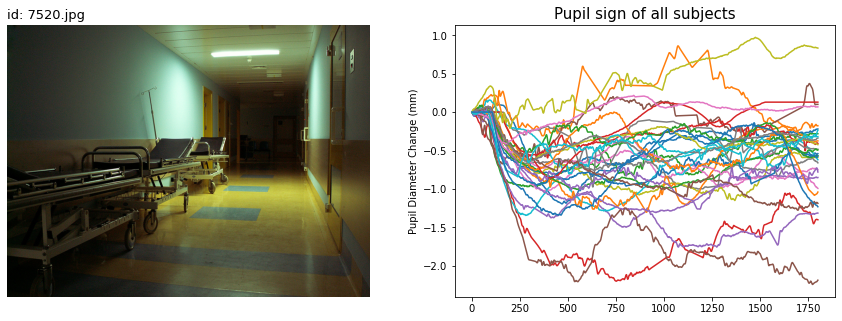

In [110]:
result_id(stimuli[17],stimuli[17])

In [111]:
# Function to calculate mean sign by class and by stimulus
def sign_class_cat(classe,stimuli):
    # preallocates space to store pupil sign
    z = np.zeros(shape=(len(classe)*len(stimuli), 1800))  
    k = 0 # Start counter
    for i in classe:
        for j in stimuli:
            # Filter subject and stimulus
            w = df2.loc[(df2["ParticipantName"]==i)&(df2["MediaName"]==j)] 
            z[k,:]=w['Pupil'] # Store subject's sign
            k = k+1 # Increment counter
    y = np.mean(z, axis=0) # Calculate the class mean  
    x = list(range(1,len(y)+1)) # Set the abscissa axis
    return y

In [112]:
# Get sign by class and type of stimulus
e_positive = sign_class_cat(p,positive)
#e_neutral = sign_class_cat(p,neutral)
e_negative = sign_class_cat(p,negative)

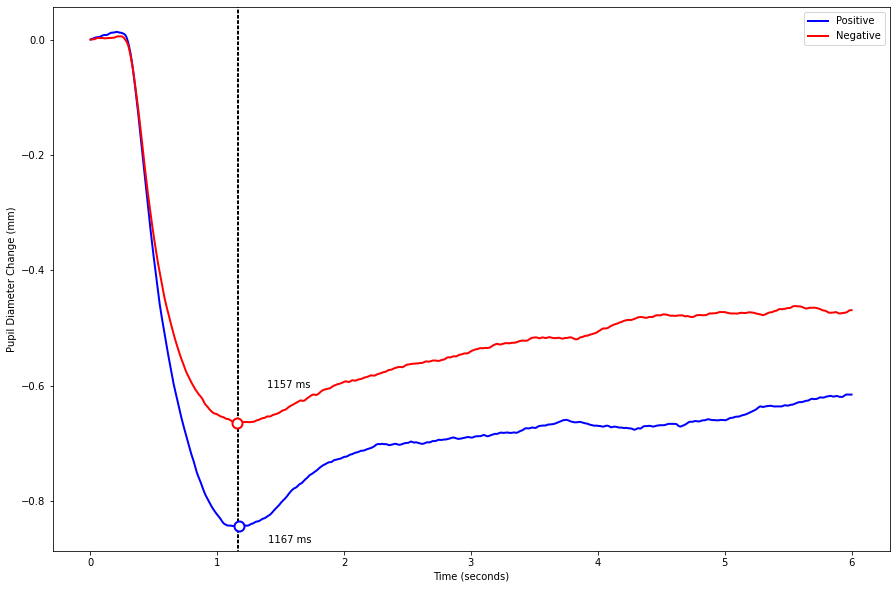

In [117]:
plt.figure(figsize=(15,10)) # Set plot area
x = list(range(1,len(e_positive)+1)) # Set the abscissa axis
g = plt.plot(x,e_positive,'blue',linewidth = 2) # Print mean sign
g = plt.plot(x,e_negative,'red',linewidth = 2) # Print mean sign


g = plt.axvline(x = [np.argmin(e_positive)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmin(e_negative)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)

g = plt.text(x[np.argmin(e_positive)]+70, e_positive[np.argmin(e_positive)]-0.03,
             str(round(np.argmin(e_positive)/300*1000))+str(' ms'), fontsize=10)
g = plt.text(x[np.argmin(e_negative)]+70, e_negative[np.argmin(e_negative)]+0.06,
             str(round(np.argmin(e_negative)/300*1000))+str(' ms'), fontsize=10)


g = plt.plot(x[np.argmin(e_positive)], e_positive[np.argmin(e_positive)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_negative)], e_negative[np.argmin(e_negative)], 'o', 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)

#g = plt.ylim(-0.025, 0.22)
g = plt.legend(['Positive','Negative']) # Insert legend
g = plt.ylabel('Pupil Diameter Change (mm)') # Insert label of the ordinate axis
g = plt.xlabel('Time (seconds)') # Insert label of the abscissa axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
plt.savefig('meanpupilchange_experts2.pdf')